In [64]:
import qiskit
import qiskit.quantum_info
from qoop.core.optimizer import adam
%load_ext autoreload
%autoreload 2
import constant
def num_params_on_active_gates(active_gates):
    num_params = 0
    for i in range(0, len(active_gates), 3):
        num_params += (active_gates[i] + active_gates[i+1]) * 3
        num_params += active_gates[i + 2] * 1
    return int(num_params)

def num_params_on_active_blocks(active_blocks):
    num_params = 0
    for _ in range(0, len(active_blocks)):
        num_params += 7
    return int(num_params)
target = None
def target_func(num_qubits, num_layers, active_blocks):
    
    thetas = np.random.uniform(0, 2*np.pi, num_params_on_active_blocks(active_blocks))
    costs, thetass = [], []
    def objective(thetas):
        U = U3cry(num_qubits, num_layers, thetas, active_blocks)
        return c_hst(U, target)
    for iter in range(constant.num_iterations):
        cost = objective(thetas)
        costs.append(cost)
        if (len(costs)> 20 and np.std(costs[-20:]) < constant.error) or cost < constant.error: # cost < constant.error:
            print('Converged')
            break
        thetass.append(thetas)
        grad = np.zeros(len(thetas))
        for j in range(0, len(thetas)):
            thetas_plus = thetas.copy()
            thetas_plus[j] += constant.shift*(0.98)**iter
            thetas_minus = thetas.copy()
            thetas_minus[j] -= constant.shift*(0.98)**iter
            grad[j] = (objective(thetas_plus) - objective(thetas_minus))/(2*constant.shift*(0.98)**iter)
        if iter == 0:
            m, v1 = list(np.zeros(thetas.shape[0])), list(
                np.zeros(thetas.shape[0]))
        thetas = adam(thetas, m, v1, iter, grad)
    return costs, thetass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
num_qubits = 3
num_layers = 2
active_blocks = np.ones((num_qubits*(num_qubits-1)//2) * num_layers) # num_blocks = num_qubits*(num_qubits-1)//2
costs, thetass = target_func(num_qubits, num_layers, active_blocks)
print(costs[-1])

600
Converged
0.00020969135000392658


1.8927069279639497e-06


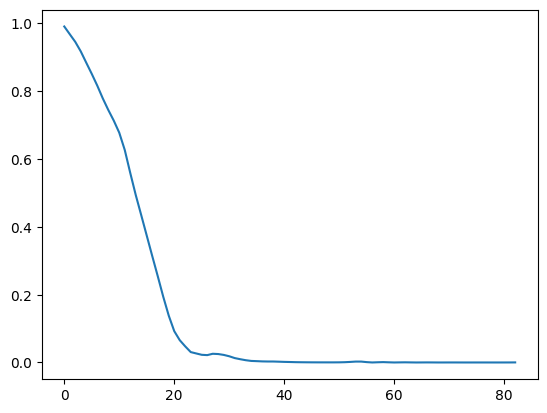

In [224]:
import matplotlib.pyplot as plt
print(np.min(costs))
plt.plot(costs)

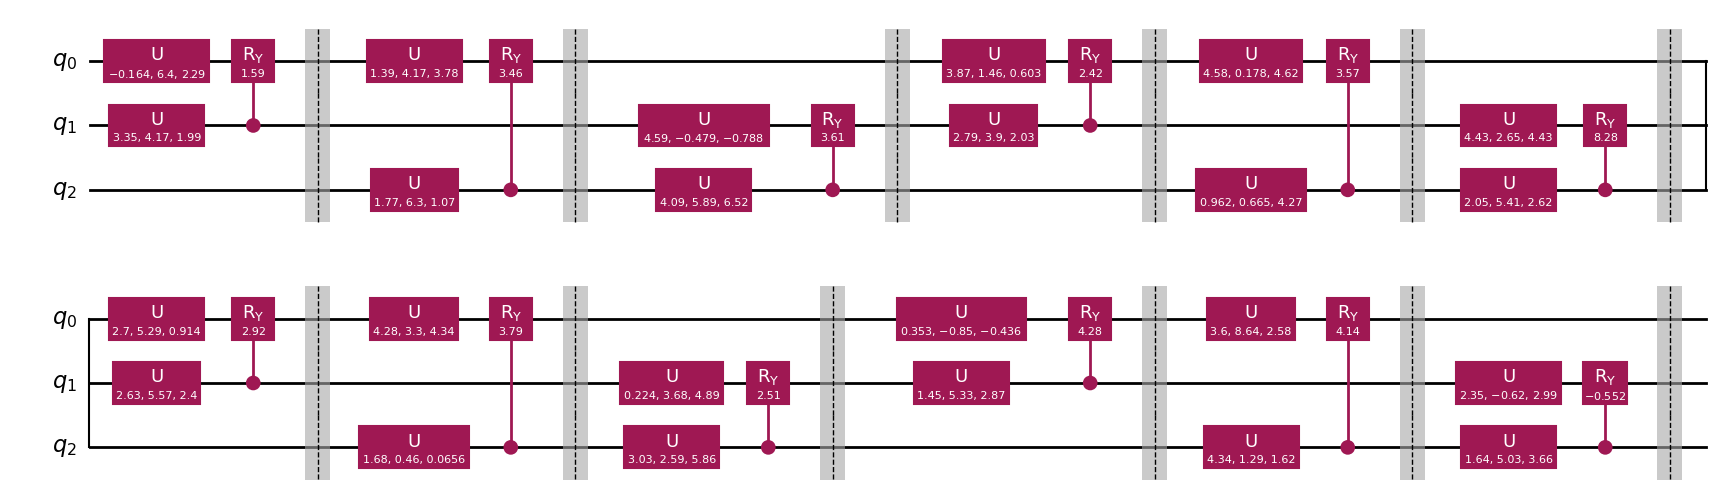

In [54]:
num_qubits = 3
num_layers = 4
num_blocks = num_qubits*(num_qubits-1)//2
active_blocks = np.ones(num_blocks * num_layers)
qc = U3cry_qc(num_qubits, num_layers, thetass[-1], active_blocks)
qc.draw('mpl')

In [65]:

target = UnitaryGate(random_unitary(2**num_qubits))

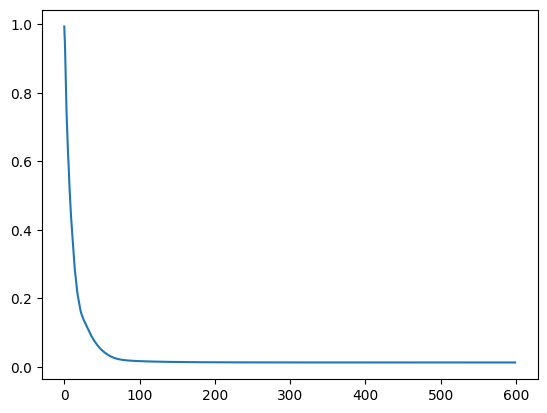

In [66]:
import time
from qiskit.circuit import ParameterVector
import matplotlib.pyplot as plt
num_qubits = 3
num_layers = 4
num_blocks = num_qubits*(num_qubits-1)//2
active_blocks = np.ones(num_blocks * num_layers)
# active_gates[2] = 0
# active_gates[5] = 0
costs, thetass = target_func(num_qubits, num_layers, active_blocks)

plt.plot(costs)

In [63]:
(0.95)**300

2.075303347768056e-07

In [67]:
np.min(costs)

0.012943919222606737

In [299]:
from qiskit.circuit.library import MCXGate
num_qubits = 5
qc = qiskit.QuantumCircuit(num_qubits)
mcx_gate1 = MCXGate(num_qubits - 1)
qc.append(mcx_gate1, range(num_qubits))
qc_excipilit = qiskit.transpile(qc, optimization_level=3)
print(qc_excipilit.count_ops())
qc_excipilit.draw('mpl')
u = np.real(qiskit.quantum_info.Operator(qc_excipilit).data)
print(f2(u, mcx_gate(num_qubits)))

OrderedDict([('cx', 18), ('cu1', 9), ('u3', 8), ('u1', 6), ('h', 2)])
0.9999999999999996


In [53]:
from qiskit.quantum_info import random_unitary
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
import qiskit
num_qubits = 3
haar_random_gate = UnitaryGate(random_unitary(2**num_qubits))
qc = QuantumCircuit(num_qubits)
qc.append(haar_random_gate, range(num_qubits))
qcx = qiskit.transpile(qc, basis_gates=['h','s','cx','u','rx','ry','rz','crx','cry','crz'], optimization_level=3)
print(qcx.count_ops())
print(theory_limit(num_qubits))
# qcx.draw('mpl')

OrderedDict([('u', 37), ('cx', 20)])
13.5


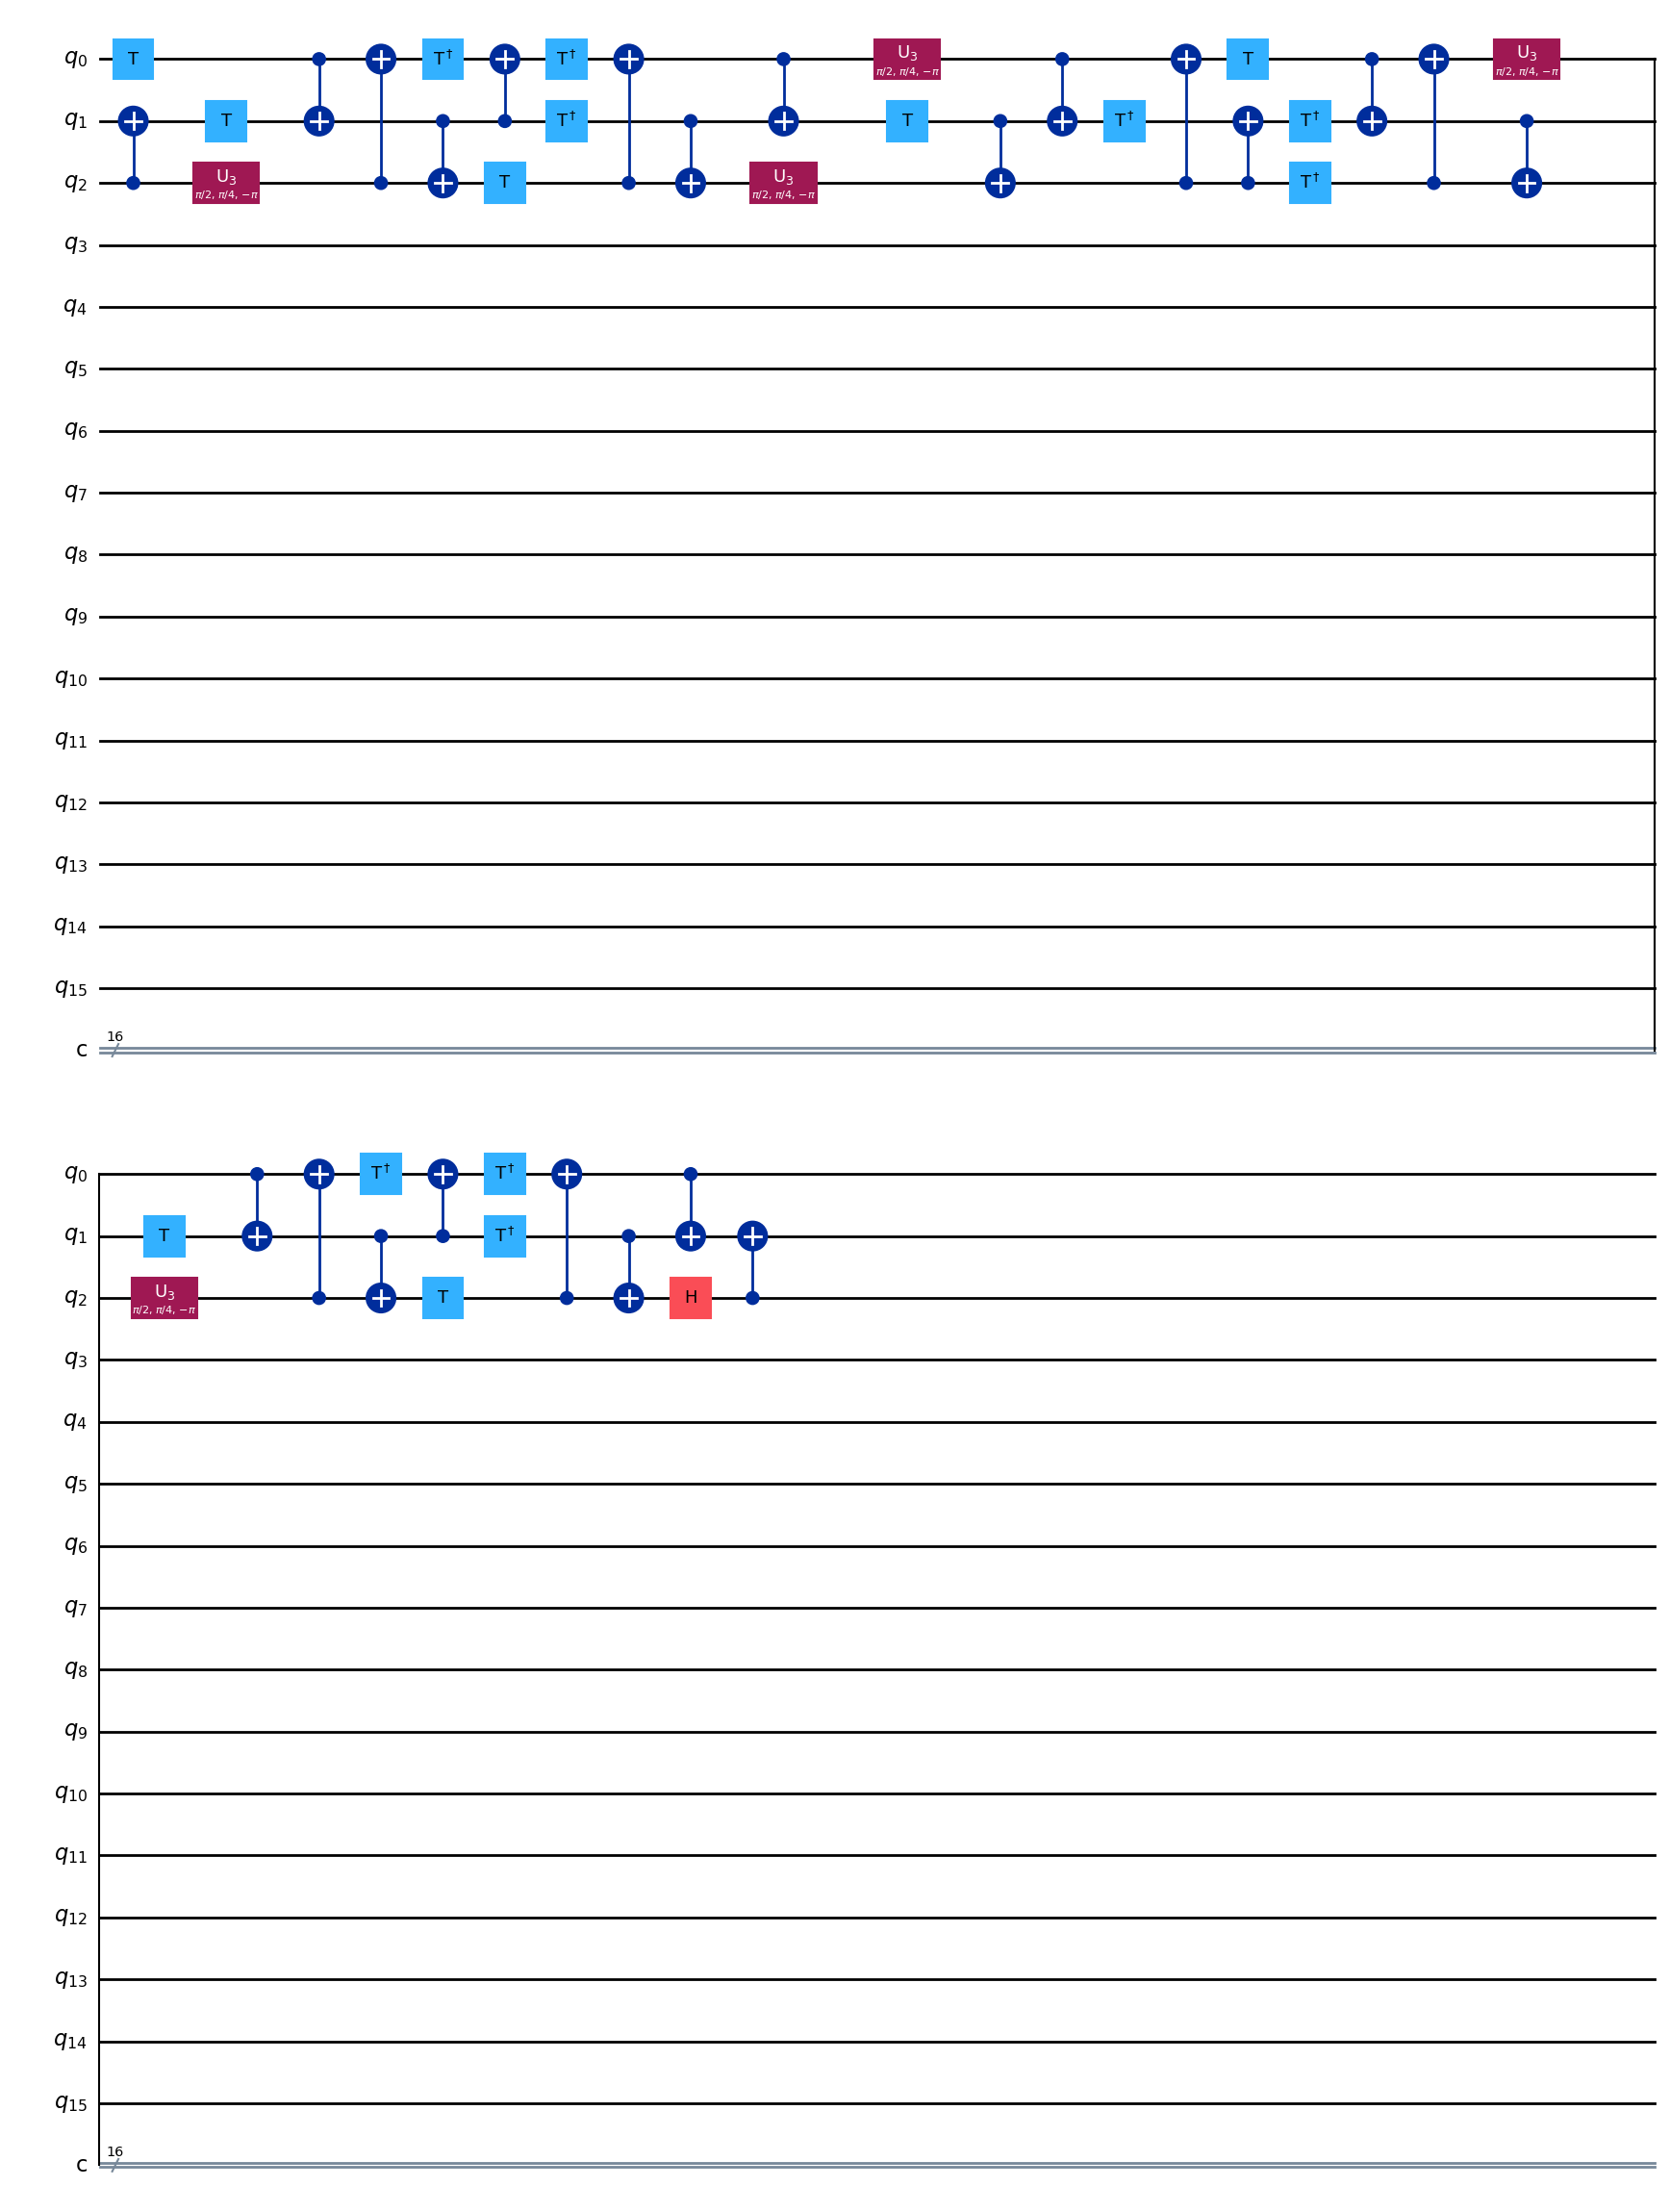

In [247]:
from qiskit import QuantumCircuit

# Read the QASM file and load it as a Qiskit QuantumCircuit
qc_from_qasm = QuantumCircuit.from_qasm_file('test.qasm')

# Display the quantum circuit
qc_from_qasm.draw('mpl')

qc_excipilit = qiskit.transpile(qc_from_qasm, optimization_level=3)
qc_excipilit.draw('mpl')

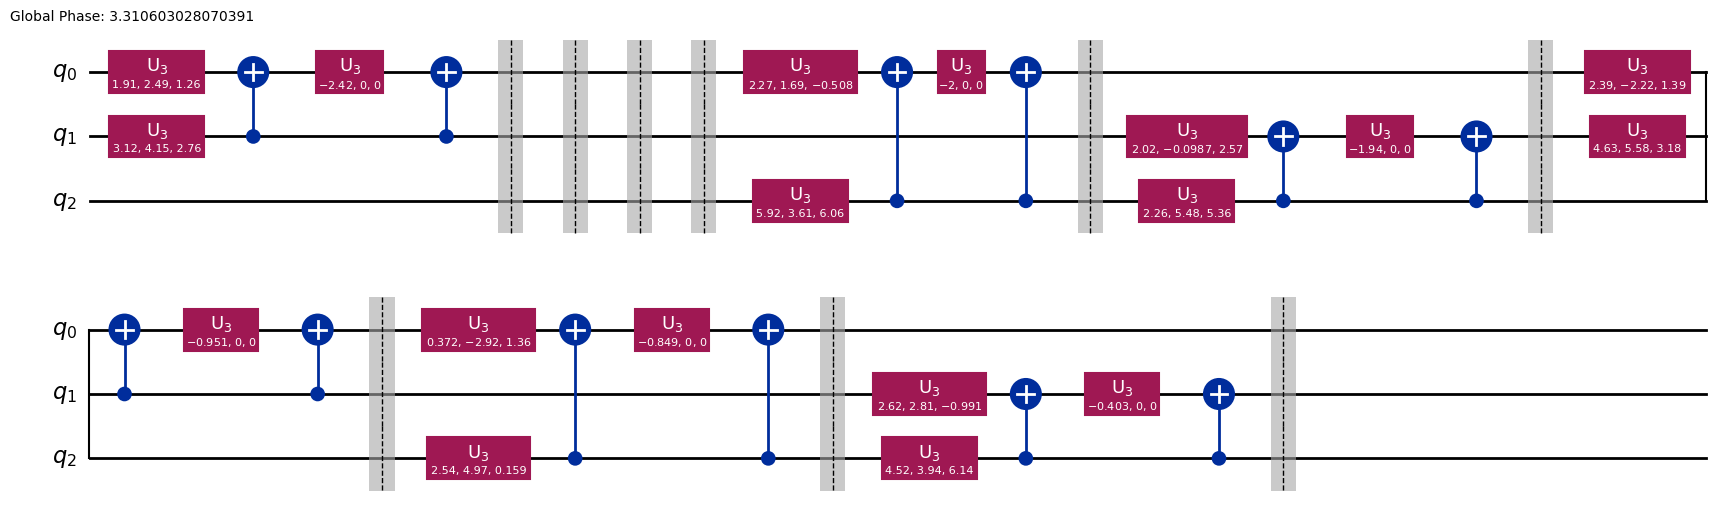

In [236]:
import qiskit
num_qubits = 3
num_layers = 3
num_blocks = num_qubits*(num_qubits-1)//2

active_blocks = [1, 0, 0, 0, 1, 1, 1, 1, 1]
thetas = np.random.uniform(0, 2*np.pi, num_params_on_active_blocks(active_blocks))
qc_x = U3cry_qc(num_qubits, num_layers, thetas, active_blocks)
qc_excipilit = qiskit.transpile(qc_x, basis_gates=['u3', 'cx'], optimization_level=3)
qc_excipilit.draw('mpl')

In [226]:
num_qubits = 3
num_layers = 2
active_blocks = np.ones((num_qubits*(num_qubits-1)//2) * num_layers) # num_blocks = num_qubits*(num_qubits-1)//2
def check(active_blocks):
    costs, _ = target_func(num_qubits, num_layers, active_blocks)
    print(np.min(costs))
    if costs[-1] < 0.001:
        return True
    return False
    # return xs[2] == 0 and xs[5] == 1
for i in range(len(active_blocks)):
    previous_sum = np.sum(active_blocks)
    for j in range(len(active_blocks)):
        if active_blocks[j] == 1:
            active_blocks[j] = 0
            print("I'm testing ...")
            k = check(active_blocks)
            print(f"{active_blocks} is {k}")
            if k == False:
                active_blocks[j] = 1
    if np.sum(active_blocks) == previous_sum:
        break
            
print(active_blocks)

I'm testing ...
Converged
0.3750075984824317
[0. 1. 1. 1. 1. 1.] is False
I'm testing ...
Converged
0.43750339008330974
[1. 0. 1. 1. 1. 1.] is False
I'm testing ...
Converged
0.1464472805532353
[1. 1. 0. 1. 1. 1.] is False
I'm testing ...
Converged
0.14644963463457217
[1. 1. 1. 0. 1. 1.] is False
I'm testing ...
Converged
0.1464501432395987
[1. 1. 1. 1. 0. 1.] is False
I'm testing ...
Converged
0.3749979104833584
[1. 1. 1. 1. 1. 0.] is False
[1. 1. 1. 1. 1. 1.]
